In [1]:
%matplotlib inline

In [2]:
import os
import asyncio
import numpy as np
import matplotlib.pyplot as plt
import mdtraj as mdt
import MDAnalysis as mda
import aimmd
import aimmd.distributed as aimmdd

Tensorflow/Keras not available


In [3]:
# setup working directory

#scratch_dir = "."
#scratch_dir = "/home/tb/hejung/DATA/aimmd_scratch/aimmd_distributed/"
scratch_dir = "/home/think/scratch/aimmd_distributed/"

workdir = os.path.join(scratch_dir, "PathSampling_mda_test")

if not os.path.isdir(workdir):
    os.mkdir(workdir)

In [4]:
# setup logging
# executing this file sets the variable LOGCONFIG, which is a dictionary of logging presets 
%run ../resources/logconf.py

In [5]:
# have a look at the default logging level (the level used for the logger without a name)
print(LOGCONFIG["loggers"][""])
# should both be `INFO`
print(LOGCONFIG["handlers"]["stdf"])

{'level': 'INFO', 'handlers': ['stdf', 'warnout']}
{'class': 'logging.FileHandler', 'level': 'INFO', 'mode': 'w', 'filename': 'simulation.log', 'formatter': 'standardFormatter'}


In [6]:
# OPTIONAL: more logging
LOGCONFIG["handlers"]["stdf"]["level"] = "DEBUG"
LOGCONFIG["loggers"][""]["level"] = "DEBUG"

In [7]:
# you can either modify single values or use it as is to get the same setup as in the OPS default logging config file
# you could e.g. do LOGCONF['handlers']['stdf']['filename'] = new_name to change the filename of the log
# the default is to create 'simulation.log' and 'initialization.log' in the current working directory
import logging.config
LOGCONFIG["handlers"]["stdf"]["filename"] = os.path.join(workdir, "simulation_pathsampling.log")
LOGCONFIG["handlers"]["initf"]["filename"] = os.path.join(workdir, "initlog_pathsampling.log")
logging.config.dictConfig(LOGCONFIG)

# now the actual setup

In [8]:
n_chains = 4  # results in 2*n_chains gmx engines

In [9]:
storage = aimmd.Storage(os.path.join(workdir, "storage.h5"))

In [10]:
# Define the engine(s) for the PathMovers
# (they will all be the same)
gro = "gmx_infiles/conf.gro"
top = "gmx_infiles/topol_amber99sbildn.top"
ndx = "gmx_infiles/index.ndx"
mdp = aimmdd.MDP("gmx_infiles/md.mdp")

#gro = "../capped_alanine_dipeptide/conf.gro"
#top = "../capped_alanine_dipeptide/topol.top"
#ndx = None
#mdp = aimmdd.MDP("../capped_alanine_dipeptide/md.mdp")


gmx_engine_kwargs = {"mdp": mdp,
                     "gro_file": gro,
                     "top_file": top,
                     "ndx_file": ndx,
                     "mdrun_extra_args": "-nt 2",
                     # use this for gmx sans (thread) MPI
                     #"mdrun_extra_args": "-ntomp 2",
                     }
gmx_engine_cls = aimmdd.GmxEngine

In [11]:
# state functions
from state_funcs_mda import alpha_R, C7_eq

wrapped_alphaR = aimmdd.PyTrajectoryFunctionWrapper(alpha_R)

wrapped_C7_eq = aimmdd.PyTrajectoryFunctionWrapper(C7_eq)

In [12]:
# descriptor_transform for the model

# internal coordinates
from state_funcs_mda import descriptor_func_ic

wrapped_transform = aimmdd.PyTrajectoryFunctionWrapper(descriptor_func_ic, call_kwargs={"molecule_selection": "protein"})

In [13]:
# load initial transitions
#tp_lb = aimmdd.Trajectory(structure_file="../capped_alanine_dipeptide/ala_md_300K.tpr",
#                          trajectory_file="../capped_alanine_dipeptide/ala_300K_TP_low_barrier_gmx_engine.trr")
tp_lb = aimmdd.Trajectory(structure_file="gmx_infiles/ala_300K_amber99sb-ildn.tpr", trajectory_file="gmx_infiles/TP_low_barrier_300K_amber99sbildn.trr")
#tp_short = aimmdd.Trajectory(structure_file="gmx_infiles/ala_300K_amber99sb-ildn.tpr", trajectory_file="gmx_infiles/ala_300K_TP.trr")
#tp2_short = aimmdd.Trajectory(structure_file="gmx_infiles/ala_300K_amber99sb-ildn.tpr", trajectory_file="gmx_infiles/ala_300K_TP2.trr")
#tp_long = aimmdd.Trajectory(structure_file="gmx_infiles/ala_300K_amber99sb-ildn.tpr", trajectory_file="gmx_infiles/ala_300K_TP_long.trr")

In [14]:
# get the descriptors for one of them to infer the number of inputs for our model
descriptors_for_tp = await wrapped_transform(tp_lb)

In [15]:
await wrapped_alphaR(tp_lb)

array([ True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [16]:
await wrapped_C7_eq(tp_lb)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True])

In [17]:
# imports for model
import torch.nn.functional as F
import torch

In [18]:
# model definition
n_lay_pyramid = 5
#n_lay_pyramid = 4
n_unit_top = 10
#n_unit_top = 6
n_unit_base = cv_ndim = descriptors_for_tp.shape[1]
fact = (n_unit_top / n_unit_base)**(1./(n_lay_pyramid))

modules = []

for i in range(1, n_lay_pyramid + 1):
    print(f"ResUnit {i} is {max(n_unit_top, int(n_unit_base * fact**(i-1)))} units wide.")
    modules += [aimmd.pytorch.networks.ResNet(n_units=max(n_unit_top, int(n_unit_base * fact**(i-1))),
                                              n_blocks=1)
                ]

    modules += [aimmd.pytorch.networks.FFNet(n_in=max(n_unit_top, int(n_unit_base * fact**(i-1))),
                                             n_hidden=[max(n_unit_top, int(n_unit_base * fact**i))],  # 1 hidden layer network
                                             activation=torch.nn.Identity(),
                                             )
                ]
#    modules += [aimmd.pytorch.networks.ResNet(n_units=max(n_unit_top, int(n_unit_base * fact**i)),
#                                              n_blocks=1)
#                ]

torch_model = aimmd.pytorch.networks.ModuleStack(n_out=1,  # using a single output we will predict only p_B and use a binomial loss
                                                           # we could have also used n_out=n_states to use a multinomial loss and predict all states,
                                                           # but this is probably only worthwhile if n_states > 2 as it would increase the number of free parameters in the NN
                                                 modules=modules,  # modules is a list of initialized torch.nn.Modules from arcd.pytorch.networks
                                                 )

# move model to GPU if CUDA is available
if torch.cuda.is_available():
    torch_model = torch_model.to('cuda')

# choose and initialize an optimizer to train the model
optimizer = torch.optim.Adam(torch_model.parameters(), lr=1e-3)

ResUnit 1 is 107 units wide.
ResUnit 2 is 66 units wide.
ResUnit 3 is 41 units wide.
ResUnit 4 is 25 units wide.
ResUnit 5 is 16 units wide.


In [19]:
"""
# create a pyramidal feed-forward architecture with a ResNet top part
n_lay_pyramid = 4  # number of layers in the pyramid
n_unit_top = 10  # number of units per layer in the top ResNet part
n_lay_top = 2  # number of ResUnits in the top part, results in n_lay_top * residual_n_skip layers
n_unit_base = cv_ndim  # number of inputs to the NN/number of units in the first layer
print('number of input descriptors: ', n_unit_base)

# calculate the factor by which we reduce the number of units per layer in the pyramidal part from layer to layer
fact = (n_unit_top / n_unit_base)**(1./(n_lay_pyramid-1))

ffnet = aimmd.pytorch.networks.FFNet(n_in=cv_ndim,
                                     n_hidden=[max(n_unit_top, int(n_unit_base * fact**i)) for i in range(n_lay_pyramid)],  # 4 hidden layer pyramidal network
                                     #activation=nn.ELU,
                                    )

resnet = aimmd.pytorch.networks.ResNet(n_units=n_unit_top, n_blocks=n_lay_top)

torch_model = aimmd.pytorch.networks.ModuleStack(n_out=1,  # using a single output we will predict only p_B and use a binomial loss
                                                           # we could have also used n_out=n_states to use a multinomial loss and predict all states,
                                                           # but this is probably only worthwhile if n_states > 2 as it would increase the number of free parameters in the NN
                                                 modules=[ffnet, resnet],  # modules is a list of initialized torch.nn.Modules from aimmd.pytorch.networks
                                                )

# move model to GPU if CUDA is available
if torch.cuda.is_available():
    torch_model = torch_model.to('cuda')

# choose and initialize an optimizer to train the model
optimizer = torch.optim.Adam(torch_model.parameters(), lr=1e-3)
#"""

"\n# create a pyramidal feed-forward architecture with a ResNet top part\nn_lay_pyramid = 4  # number of layers in the pyramid\nn_unit_top = 10  # number of units per layer in the top ResNet part\nn_lay_top = 2  # number of ResUnits in the top part, results in n_lay_top * residual_n_skip layers\nn_unit_base = cv_ndim  # number of inputs to the NN/number of units in the first layer\nprint('number of input descriptors: ', n_unit_base)\n\n# calculate the factor by which we reduce the number of units per layer in the pyramidal part from layer to layer\nfact = (n_unit_top / n_unit_base)**(1./(n_lay_pyramid-1))\n\nffnet = aimmd.pytorch.networks.FFNet(n_in=cv_ndim,\n                                     n_hidden=[max(n_unit_top, int(n_unit_base * fact**i)) for i in range(n_lay_pyramid)],  # 4 hidden layer pyramidal network\n                                     #activation=nn.ELU,\n                                    )\n\nresnet = aimmd.pytorch.networks.ResNet(n_units=n_unit_top, n_blocks=n_lay

In [20]:
# we take an ExpectedEfficiencyPytorchRCModel,
# this RCmodel scales the learning rate by the expected efficiency factor (1 - n_TP_true / n_TP_expected)**2
model = aimmd.pytorch.EEScalePytorchRCModelAsync(nnet=torch_model,
                                                 optimizer=optimizer,
                                                 states=[wrapped_C7_eq, wrapped_alphaR],
                                                 ee_params={'lr_0': 1e-3,  
                                                            #'lr_min': 5e-5,  # lr_min = lr_0 / 20 is a good choice empirically
                                                            'lr_min': 5e-5,
                                                            #'epochs_per_train': 3, # try 5, [10 and 15] next
                                                            'epochs_per_train': 5,
                                                            #'interval': 5,
                                                            'interval': 10,
                                                            #'window': 75,
                                                            'window': 100,
                                                           },
                                                 descriptor_transform=wrapped_transform,
                                                 cache_file=storage,
                                                 )

In [21]:
aimmd.pytorch.EEScalePytorchRCModel.__mro__

(aimmd.pytorch.rcmodel.EEScalePytorchRCModel,
 aimmd.pytorch.rcmodel.EEScalePytorchRCModelMixin,
 aimmd.pytorch.rcmodel.PytorchRCModel,
 aimmd.base.rcmodel.RCModel,
 abc.ABC,
 object)

In [22]:
aimmd.pytorch.EEScalePytorchRCModelAsync.__mro__

(aimmd.pytorch.rcmodel.EEScalePytorchRCModelAsync,
 aimmd.pytorch.rcmodel.EEScalePytorchRCModelMixin,
 aimmd.pytorch.rcmodel.PytorchRCModelAsync,
 aimmd.base.rcmodel.RCModelAsyncMixin,
 aimmd.pytorch.rcmodel.PytorchRCModel,
 aimmd.base.rcmodel.RCModel,
 abc.ABC,
 object)

In [23]:
# we could use a list with initialized movers
#movers = [[aimmdd.TwoWayShootingPathMover(states=[wrapped_C7_eq, wrapped_alphaR],
#                                          engine_cls=gmx_engine_cls,
#                                          engine_kwargs=gmx_engine_kwargs,
#                                          engine_config=mdp,
#                                          walltime_per_part=0.01,
#                                          T=mdp["ref-t"][0],
#                                         )
#           ] for i in range(n_chains)
#         ]

# it is easier though to use the `Brain.chains_from_moverlist()` function
# this function will create n-chain identical PathSamplingChains where the movers for each chain are
# specified by movers_cls (a list of mover classes) and movers_kwargs (a dict with keyword arguments used for initialization of the movers)
movers_cls = [aimmdd.pathmovers.TwoWayShootingPathMover]
movers_kwargs = [{'states': [wrapped_alphaR, wrapped_C7_eq],
                  'engine_cls': gmx_engine_cls,
                  'engine_kwargs': gmx_engine_kwargs,
                  # NOTE: choose this as short as possible!
                  #       since ala is super-small and commits fast we should make sure
                  #       that most trials reach a state in the first part
                  #       this in turn makes sure that we do not call gromasc multiple times per trial (saving setup time)
                  #       but still ensures that the resulting trajectories are not too long and large
                  #       it also reduces the time needed per step (we need at least walltime_per_part hours per step)
                  #'walltime_per_part': 0.000015625,  # 0.055125 s per part
                  #'walltime_per_part': 0.00003125,  # 0.1125 s per part
                  'walltime_per_part': 0.0000625,  # 0.225 s per part
                  #'walltime_per_part': 0.000125,  # 0.45 s per part
                  #'walltime_per_part': 0.00025,  # 0.9 s per part
                  #'walltime_per_part': 0.0005,  # 1.8 s per part
                  #'walltime_per_part': 0.001,  # 3.6 s per part
                  #'walltime_per_part': 0.002,  # 7.2 s per part
                  #'walltime_per_part': 0.003,  # 10.8 s per part
                  #'walltime_per_part': 0.004,  # 14.4 s per part
                  'T': mdp["ref-t"][0],
                  "sp_selector": aimmdd.pathmovers.RCModelSPSelector(),  # can be used to customize SP-selection params 
                  }
                 ]

In [24]:
trainset = aimmd.TrainSet(n_states=2)

In [25]:
tasks = [aimmdd.pathsampling.TrainingTask(model=model, trainset=trainset),
         aimmdd.pathsampling.SaveTask(storage=storage, model=model, trainset=trainset),
         aimmdd.pathsampling.DensityCollectionTask(model=model,
                                                   first_collection=100,
                                                   recreate_interval=500,
                                                   interval=10
                                                   ),
         ]

In [26]:
# this would be the full __init__ call to the brain
# it gives you full flexibility of setting up every PathSamplingChain individually
#brain = aimmdd.Brain(model=model, workdir=workdir, storage=storage, movers=movers, mover_weights=[[1.], [1.], [1.]], tasks=tasks)

# this is the 'easy' way
brain = aimmdd.Brain.chains_from_moverlist(model=model, workdir=workdir, storage=storage, n_chain=n_chains,
                                           movers_cls=movers_cls, movers_kwargs=movers_kwargs, tasks=tasks)
                                           # Note that we left mover_weights=None at its default, this results
                                           # in uniform weights for all movers

In [27]:
# NOTE: old cumbersome setup

#initial_step = aimmdd.logic.MCstep(mover=None, stepnum=0, directory="gmx_infiles", path=tp_short, accepted=True)
#initial_step2 = aimmdd.logic.MCstep(mover=None, stepnum=0, directory="gmx_infiles", path=tp_long, accepted=True)

# take two different initial TPs
#for i, c in enumerate(brain.chains):
#    if i == 2:
#        c.current_step = initial_step2
#        c.chainstore.append(initial_step2)  # save the initial step as first step of every chain
#    else:
#        c.current_step = initial_step
#        c.chainstore.append(initial_step)  # save the initial step as first step of every chain


# NEW: use the new seed_initial_paths() method!
# have a look at before
for i, c in enumerate(brain.chains):
    print(f"Chain {i}: ", c.current_step)
    print()
# seed them
#brain.seed_initial_paths(trajectories=[tp_short, tp2_short, tp_long], weights=[1., 1., 2.])
brain.seed_initial_paths(trajectories=[tp_lb], weights=[1.])
# have a look again
for i, c in enumerate(brain.chains):
    print(f"Chain {i}: ")
    print(f"MCstep {c.current_step}, with path {c.current_step.path}.")
    print()

Chain 0:  None

Chain 1:  None

Chain 2:  None

Chain 3:  None

Chain 0: 
MCstep <aimmd.distributed.pathmovers.MCstep object at 0x7fb6ddc9abb0>, with path Trajectory(trajectory_file=/home/think/Documents/sources/OPS/aimmd/examples/distributed/gmx_infiles/TP_low_barrier_300K_amber99sbildn.trr, structure_file=/home/think/Documents/sources/OPS/aimmd/examples/distributed/gmx_infiles/ala_300K_amber99sb-ildn.tpr).

Chain 1: 
MCstep <aimmd.distributed.pathmovers.MCstep object at 0x7fb6ddc97760>, with path Trajectory(trajectory_file=/home/think/Documents/sources/OPS/aimmd/examples/distributed/gmx_infiles/TP_low_barrier_300K_amber99sbildn.trr, structure_file=/home/think/Documents/sources/OPS/aimmd/examples/distributed/gmx_infiles/ala_300K_amber99sb-ildn.tpr).

Chain 2: 
MCstep <aimmd.distributed.pathmovers.MCstep object at 0x7fb6df71cf70>, with path Trajectory(trajectory_file=/home/think/Documents/sources/OPS/aimmd/examples/distributed/gmx_infiles/TP_low_barrier_300K_amber99sbildn.trr, structur

In [28]:
await brain.run_for_n_steps(100)
#await brain.run_for_n_steps(2000)
#await brain.run_for_n_accepts(25)

In [29]:
print(model.log_train_decision[-1])

[False, 0.001, 5, None]


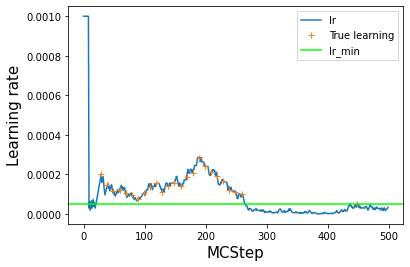

In [30]:
# lets have a look at the value of the learning rate over the course of training
# note however, that we did not train at every step, but just at every interval MCsteps
log_train = np.array(model.log_train_decision)
lr = log_train[:,1]
plt.plot(lr, label='lr')
# see where we really trained: everywhere where train=True
# set lr_true to NaN anywhere where we did not train to have a nice plot
lr_true = lr
lr_true[log_train[:,0] == False] = np.nan
plt.plot(lr_true, '+', label='True learning')
# lr_min as a guide to the eye
plt.axhline(model.ee_params['lr_min'], label='lr_min', color='lime')
plt.legend()
plt.xlabel('MCStep', size=15);
plt.ylabel('Learning rate', size=15);

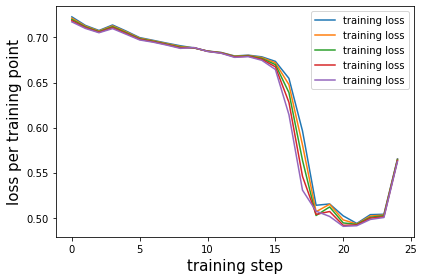

In [31]:
# the model losses at each step where it trained
# this will be epochs_per_training loss values per training
plt.plot(model.log_train_loss, label='training loss')
plt.legend();
plt.ylabel('loss per training point', size=15)
plt.xlabel('training step', size=15)
plt.tight_layout()

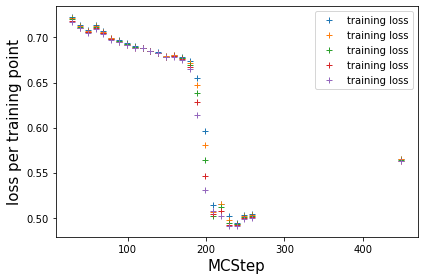

In [32]:
# resort such that we have a loss value per MCStep, NaN if we did not train at that step
train_loss = []
count = 0
for t in log_train[:, 0]:
    if t:
        train_loss.append(model.log_train_loss[count])
        count += 1
    else:
        train_loss.append([np.nan for _ in range(model.ee_params['epochs_per_train'])])
    
plt.plot(train_loss, '+', label='training loss')
plt.legend();
plt.ylabel('loss per training point', size=15)
plt.xlabel('MCStep', size=15)
plt.tight_layout()

In [33]:
# TODO: find a way, currently it is not possibly to get the accepts in the same order as the trainset?!
# TODO: probably we will have to write a DataCollectionTask to achieve that ?!
# get accepts from storage:
# NOTE: this is just roughly the right order
accepts = []
for accs in zip(*(c.accepts for c in brain.chains)):
    accepts += list(accs)

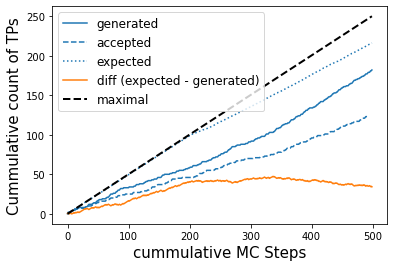

In [34]:
# plot efficiency, expected efficiency and accepts
# Note: this will only work for models with n_out=1, due to the way we calculate p(TP|x)

p_ex = np.array(model.expected_p)

l, = plt.plot(np.cumsum(trainset.transitions), label='generated');
plt.plot(np.cumsum(accepts), c=l.get_color(), ls='--', label='accepted');
plt.plot(np.cumsum(2*p_ex*(1 - p_ex)),c=l.get_color(), ls=':', label='expected');
plt.plot(np.cumsum(2*p_ex*(1 - p_ex))- np.cumsum(trainset.transitions), label='diff (expected - generated)')
plt.plot(np.linspace(0., len(trainset)/2., len(trainset)), c='k', ls='--', label='maximal', lw=2)
plt.legend(fontsize=12);
plt.ylabel('Cummulative count of TPs', size=15)
plt.xlabel('cummulative MC Steps', size=15);

In [63]:
hipr = aimmd.analysis.HIPRanalysis(model, trainset)

In [64]:
hipr_plus_losses, hipr_plus_stds = hipr.do_hipr_plus(25)

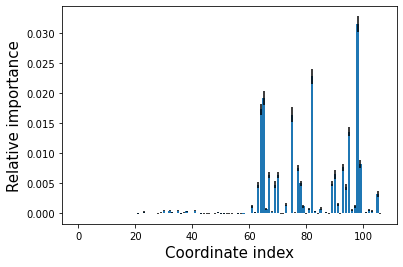

In [65]:
loss_diffs = hipr_plus_losses[:-1] - hipr_plus_losses[-1]  # hipr_losses[-1] is the reference loss over the unaltered trainset

plt.bar(np.arange(len(loss_diffs)), loss_diffs, yerr=hipr_plus_stds[:-1])
plt.xlabel('Coordinate index', size=15)
plt.ylabel('Relative importance', size=15);

In [66]:
from state_funcs_mda import generate_atomgroups_for_ic

u = mda.Universe("gmx_infiles/ala_300K_amber99sb-ildn.tpr", "gmx_infiles/conf.gro",
                 refresh_offsets=True, tpr_resid_from_one=True)
molecule = u.select_atoms('protein')
pairs, triples, quadruples = generate_atomgroups_for_ic(molecule)

In [67]:
# what are the most important contributors?
max_idxs = np.argsort(loss_diffs)[::-1]
sf_parms = {}

#pairs, triples, quadruples = aimmd.coords.internal.generate_indices(traj.topology, source_idx=1)

ic_parms = {"pairs": pairs, "triples": triples, "quadruples": quadruples}

print('reference loss:', hipr_plus_losses[-1])
for idx in max_idxs[:10]:
    print()
    print('loss for idx {:d}: '.format(idx), hipr_plus_losses[idx])
    if idx < len(pairs[0]):
        print(f"bond between: {pairs[0][idx]} and {pairs[1][idx]}")
        continue
    idx -= len(pairs[0])
    if idx < len(triples[0]):
        print(f"angle between {triples[0][idx]}, {triples[1][idx]} and {triples[2][idx]}")
        continue
    idx -= len(triples[0])
    if idx % 2 == 0:
        st = "sinus"
    else:
        st = "cosinus"
    st += f" of dihedral between {quadruples[0][idx // 2]}, {quadruples[1][idx // 2]}, {quadruples[2][idx // 2]} and {quadruples[3][idx // 2]}."
    print(st)
    #print(aimmd.coords.get_involved(idx, sf_parms=sf_parms, ic_parms=ic_parms, solvent_atoms=[['O', 'H']], solvent_resname=['HOH']))

reference loss: 0.6015825992584228

loss for idx 98:  0.6330905993232727
cosinus of dihedral between <Atom 12: HB1 of type HC of resname ALA, resid 2 and segid seg_0_Protein_chain_A>, <Atom 11: CB of type CT of resname ALA, resid 2 and segid seg_0_Protein_chain_A>, <Atom 9: CA of type CT of resname ALA, resid 2 and segid seg_0_Protein_chain_A> and <Atom 15: C of type C of resname ALA, resid 2 and segid seg_0_Protein_chain_A>.

loss for idx 82:  0.6243864334793091
cosinus of dihedral between <Atom 7: N of type N of resname ALA, resid 2 and segid seg_0_Protein_chain_A>, <Atom 9: CA of type CT of resname ALA, resid 2 and segid seg_0_Protein_chain_A>, <Atom 15: C of type C of resname ALA, resid 2 and segid seg_0_Protein_chain_A> and <Atom 17: N of type N of resname NME, resid 3 and segid seg_0_Protein_chain_A>.

loss for idx 65:  0.6208222337265015
sinus of dihedral between <Atom 4: HH33 of type HC of resname ACE, resid 1 and segid seg_0_Protein_chain_A>, <Atom 1: CH3 of type CT of resname

In [2]:
%%bash
which gmx

/usr/local/gromacs-2020.4/bin/gmx


In [46]:
(await wrapped_transform(storage.central_memory[0][8].path)).shape

(46, 99)

In [ ]:
for s in brain.storage.central_memory[0][:5]:
    print(s.mover)
    print(s.mover is brain.chains[0].movers[0])
    print(s.mover == brain.chains[0].movers[0])

In [61]:
storage.close()